# Generate a Histogram Based Noise Model
We will use pairs of noisy observations $x_i$ and clean signal $s_i$ (created by averaging many noisy images) to estimate the conditional distribution $p(x_i|s_i)$.
Note that this noise model is independent of the image content. It is a property of the camera and imaging conditions. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

import pn2v.utils
import pn2v.histNoiseModel
from tifffile import imread

### Download the data
Thanks to Britta Schroth-Diez for recording this data!

In [2]:
# Download data
import os
import urllib
import zipfile
os.system("rm -r data")
if not os.path.isdir('./data'):
    os.mkdir('./data')

zipPath="data/Convallaria_diaphragm.zip"
if not os.path.exists(zipPath):  
    data = urllib.request.urlretrieve('https://cloud.mpi-cbg.de/index.php/s/BE8raMtHQlgLDF3/download', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

### The data
The noise model is a characteristic of your camera.
To measure your noise model you have record a series of images, using the same camera and imaging settings (gain, em-gain, read-out-parameters,...) as in your experiments.
However, the content of these images does not matter, as long as they cover the required range of intensities.
We recommend to simply record 500 images of your slightly closed and defocussed field diaphragm (see images below).
It is important that your exposure, lighting and all imaging settings are constant for the entire sequence and that **NOTHING IN THE IMAGE IS MOVING**.
When recording a image sequence like this, make sure to cover desired range of intensities but **DO NOT  SATURATE** your detector.

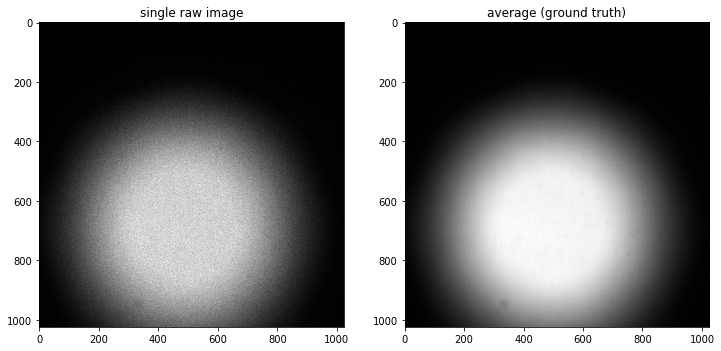

In [3]:
path="data/Convallaria_diaphragm/"

observation= imread(path+'20190726_tl_50um_500msec_wf_130EM_FD.tif')

# The data contains 100 images of a static sample.
# We estimate the clean signal by averaging all images.
signal=np.mean(observation[:,...],axis=0)[np.newaxis,...]

# Let's look the raw data and our pseudo ground truth signal
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 2)
plt.title(label='average (ground truth)')
plt.imshow(signal[0],cmap='gray')
plt.subplot(1, 2, 1)
plt.title(label='single raw image')
plt.imshow(observation[0],cmap='gray')
plt.show()

Let us first take a look at the distribution of signals $s_i$ that are present in this data.
While most pixels are background, we comfortably cover a range to values of 30000 and below. The signals in the images we want to denoise should be within this range.

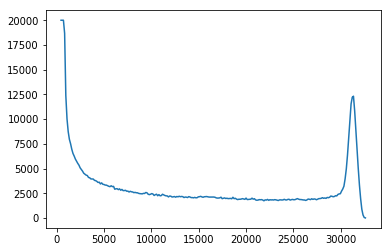

In [4]:
checkSignalHist = np.histogram(signal, bins=256)
plt.plot( checkSignalHist[1][:-1], np.clip(checkSignalHist[0],0,20000))

### Creating the noise model
Using the raw pixels $x_i$, and our pseudo ground truth $s_i$, we are now creating a 2D histogram. Rows correspond to different signals $s_i$ and columns to different observations $x_i$. The histogram is normalized so that every row sums to one. It describes the distribution $p(x_i|s_i)$ for each $s_i$. This distribution is our noise model.

In [5]:
# We set the range of values we want to cover with our model.
# The pixel intensities in the images you want to denoise have to lie within this range.
# We expect our intensities to lie within [350,6500].
minVal, maxVal =350, 6500
bins = 256

# We are creating the histogram.
# This can take a minute.
histogramFD = pn2v.histNoiseModel.createHistogram(bins,minVal,maxVal,observation,signal)

# Saving histogram to disc.
np.save(path+'noiseModel.npy', histogramFD)

histogramFD=histogramFD[0]

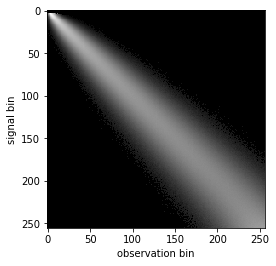

In [6]:
# Let's look at the noise model
plt.xlabel('observation bin')
plt.ylabel('signal bin')
plt.imshow(histogramFD**0.25, cmap='gray')
plt.show()


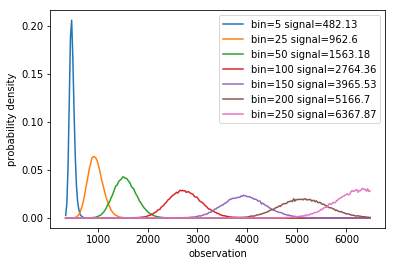

In [7]:
xvals=np.arange(bins)/float(bins)*(maxVal-minVal)+minVal
plt.xlabel('observation')
plt.ylabel('probability density')

# We will now look at the noise distributions for different signals s_i,
# by plotting individual rows of the histogram
index=5
s=((index+0.5)/float(bins)*(maxVal-minVal)+minVal)
plt.plot(xvals,histogramFD[index,:], label='bin='+str(index)+' signal='+str(np.round(s,2)))

index=25
s=((index+0.5)/float(bins)*(maxVal-minVal)+minVal)
plt.plot(xvals,histogramFD[index,:], label='bin='+str(index)+' signal='+str(np.round(s,2)))

index=50
s=((index+0.5)/float(bins)*(maxVal-minVal)+minVal)
plt.plot(xvals,histogramFD[index,:], label='bin='+str(index)+' signal='+str(np.round(s,2)))

index=100
s=((index+0.5)/float(bins)*(maxVal-minVal)+minVal)
plt.plot(xvals,histogramFD[index,:], label='bin='+str(index)+' signal='+str(np.round(s,2)))

index=150
s=((index+0.5)/float(bins)*(maxVal-minVal)+minVal)
plt.plot(xvals,histogramFD[index,:], label='bin='+str(index)+' signal='+str(np.round(s,2)))

index=200
s=((index+0.5)/float(bins)*(maxVal-minVal)+minVal)
plt.plot(xvals,histogramFD[index,:], label='bin='+str(index)+' signal='+str(np.round(s,2)))

index=250
s=((index+0.5)/float(bins)*(maxVal-minVal)+minVal)
plt.plot(xvals,histogramFD[index,:], label='bin='+str(index)+' signal='+str(np.round(s,2)))

plt.legend()
plt.show()